In [ ]:
# handling missing values, categorical variables
# design pipelines to improve the quality of the ml code
# advanced model validation techniques: cross-validation
# state-of-the-art ml models: XGBoost
# avoid data leakage

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# plt.style.use('seaborn-whitegrid') # depricated
sns.set(style= 'whitegrid')
plt.rc('figure', autolayout= True)

plt.rc(
    'axes',
    labelweight= 'bold',
    labelsize= 'large',
    titleweight= 'bold',
    titlesize= 14,
    titlepad= 10,
)

In [ ]:
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
!pip install --upgrade xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 4.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cudnn-cu12==8.9.2.26; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requ

In [ ]:
import xgboost as xgb
print(xgb.__version__)

2.1.1


In [ ]:
df = pd.read_csv('./cr_loan2.csv')
df.shape

(32581, 12)

In [ ]:
X_trn = df.sample(2000)
X_tst = df.sample(1000)

In [ ]:
X_trn.head(3)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
27203,28,126000,MORTGAGE,2.0,HOMEIMPROVEMENT,B,12000,11.71,0,0.10,N,7
6409,24,33000,RENT,3.0,DEBTCONSOLIDATION,D,6000,15.62,1,0.18,N,2
1964,23,10000,RENT,1.0,VENTURE,B,2100,12.21,1,0.21,N,3


In [ ]:
X_trn.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')

In [ ]:
cols_num = ['person_age', 'person_income', 'person_emp_length', 'loan_percent_income',
            'cb_person_cred_hist_length']
cols_cat = ['person_home_ownership', 'loan_intent']

In [ ]:
cols = cols_num + cols_cat

X_trn[cols].isna().sum()

,0
person_age,0
person_income,0
person_emp_length,51
person_home_ownership,0
loan_intent,0


## Missing Values

In [ ]:
# Three approaches:
# 1) drop columns with missing values
# 2) imputation: mean/median value, most common value
# 3) an extension to imputation
# imputed values may be systematically above or below their actual values
# (which were not collected in the dataset.)
# Or rows with missing values may be unique in some other way.
# => imputation + na_indicator (0/1)


# always inspect the data
# for example, if a column is `year_garage_built`
# na could mean the house doesn't have a garage
# also, even if a house has a garage, imputing mean value could be stupid
# as the mean for the `year_garage_built` may be before even a specific house was built.
#=> Know your data.

In [ ]:
hasna = X_trn.isna().sum()
hasna[hasna > 0]


,0
person_emp_length,49
loan_int_rate,207


In [ ]:
cols_with_na = [col for col in X_trn.columns if X_trn[col].isnull().any()]
X_trn.drop(cols_with_na, axis= 1).shape

(2000, 10)

In [ ]:
cols_with_na

['person_emp_length', 'loan_int_rate']

In [ ]:
for col in cols_with_na:
    X_trn['isna_' + col] = X_trn[col].isnull()
    X_tst['isna_' + col] = X_tst[col].isnull()

In [ ]:
imputer = SimpleImputer(strategy= 'mean')

X_trn_imputed = pd.DataFrame(imputer.fit_transform(X_trn[cols_num]))
X_trn_imputed.columns = X_trn[cols_num].columns

X_trn_imputed.isna().sum().sum()

0

## categorical variables

### ordinal encoding

In [ ]:
# 1) ordinal encoding:
# suitable when there's an indisputable randing to the categories
# "never" < "rarely" < "most days" < "every day" [0 < 1 < 2 < 3]
# N.B. sure, the ordering makes sense; but what about the difference?
# e.g. why not 0 < 1 < 3 < 10 ? :D

# for tree-based models, you could expect ordinal encoding to work well.

In [ ]:
is_object = X_trn.dtypes == 'object'
cat_cols = list(is_object[is_object].index)
cat_cols

['person_home_ownership',
 'loan_intent',
 'loan_grade',
 'cb_person_default_on_file']

In [ ]:
X_trn.select_dtypes(exclude= ['object']).shape

(2000, 10)

In [ ]:
X_trn.drop(cat_cols, axis= 1).columns

Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_cred_hist_length', 'isna_person_emp_length',
       'isna_loan_int_rate'],
      dtype='object')

In [ ]:
X_trn.shape

(2000, 14)

In [ ]:
encoder_ordinal = OrdinalEncoder()
encoder_ordinal

OrdinalEncoder()

In [ ]:
# This randomly assigned each unique value to a different integer:
encoder_ordinal.fit_transform(X_trn[cat_cols])

array([[3., 4., 1., 0.],
       [0., 1., 1., 0.],
       [0., 0., 2., 1.],
       ...,
       [3., 1., 3., 1.],
       [0., 1., 1., 0.],
       [0., 5., 1., 0.]])

In [ ]:
encoder_ordinal.transform(X_tst[cat_cols])

array([[0., 5., 2., 1.],
       [3., 2., 3., 0.],
       [3., 4., 2., 0.],
       ...,
       [2., 2., 1., 0.],
       [0., 2., 0., 0.],
       [3., 4., 1., 0.]])

In [ ]:
# We can expect an additional boost in performance
# if we provide better-informed lables for all the ordinal variables.

In [ ]:
XX = X_trn.copy()

XX[cat_cols] = encoder_ordinal.transform(XX[cat_cols])
XX[cat_cols].sample(10)

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
21513,2.0,5.0,2.0,0.0
8498,3.0,3.0,3.0,1.0
32149,3.0,0.0,1.0,0.0
13411,0.0,2.0,3.0,0.0
18274,3.0,4.0,1.0,0.0
5711,0.0,4.0,0.0,0.0
18572,3.0,2.0,1.0,0.0
11776,0.0,4.0,0.0,0.0
19461,2.0,1.0,0.0,0.0
8118,0.0,2.0,2.0,1.0


### one-hot encoding

In [ ]:
# 2) one-hot encoding
# one-hot encoding does not assume an ordering of the categories:
# we refer to categorical variables without an intrinsic ranking as "nominal variables".
# this approach is not the best idea if the categorical variable takes on a large number of values.
# as it will greatly expand the size of the dataset.
# perhaps some merging of categories would be beneficial.

In [ ]:
# handle_unknown= 'ignore': in case there are unseen categories in validation or test set.
# Otherwise the encoder doesn't know how to handle them.
# REMEMBER: such pre-processings should only be based on the training set.
# sparse= False: return result will be a numpy array (and not a sparse matrix)
encoder_1hot = OneHotEncoder(handle_unknown= 'ignore', sparse= False)

In [ ]:
XX_trn = X_trn.copy()
XX_tst = X_tst.copy()

X_trn_1hot = pd.DataFrame(encoder_1hot.fit_transform(XX_trn[cat_cols]))
X_tst_1hot = pd.DataFrame(encoder_1hot.transform(X_tst[cat_cols]))

# 1hot removes index, put them back:
X_trn_1hot.index = XX_trn.index
X_tst_1hot.index = XX_tst.index

# drop the categorical columns:
X_trn_num = XX_trn.drop(cat_cols, axis= 1)
X_tst_num = XX_tst.drop(cat_cols, axis= 1)

# Add 1hot columns to the numerical features:
XX_trn = pd.concat([X_trn_num, X_trn_1hot], axis= 1)
XX_tst = pd.concat([X_tst_num, X_tst_1hot], axis= 1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# This should also be handles
# at the very least, the column names should be converted to string
# but the best is to know what '0' refers to, or what '12' refers to
XX_trn.columns

Index([                'person_age',              'person_income',
                'person_emp_length',                  'loan_amnt',
                    'loan_int_rate',                'loan_status',
              'loan_percent_income', 'cb_person_cred_hist_length',
           'isna_person_emp_length',         'isna_loan_int_rate',
                                  0,                            1,
                                  2,                            3,
                                  4,                            5,
                                  6,                            7,
                                  8,                            9,
                                 10,                           11,
                                 12,                           13,
                                 14,                           15,
                                 16,                           17,
                                 18],
      dtype='object')

In [ ]:
X_trn[cat_cols].nunique()

,0
person_home_ownership,4
loan_intent,6
loan_grade,7
cb_person_default_on_file,2


In [ ]:
n = list(map(lambda col: X_trn[col].nunique(), cat_cols))
d = dict(zip(cat_cols, n))
sorted(d.items(), key= lambda itm: itm[1])

[('cb_person_default_on_file', 2),
 ('person_home_ownership', 4),
 ('loan_intent', 6),
 ('loan_grade', 7)]

### target encoding

In [ ]:
# target encoding:
# any kind of encoding that replaces a feature's categories with some number
# derived from the target variable.

# it's what we call a supervised feature engineering technique,
# as it also uses the **target** to create the encoding.

In [ ]:
X_trn.value_counts('loan_intent')

,count
loan_intent,
EDUCATION,404
MEDICAL,356
VENTURE,354
DEBTCONSOLIDATION,338
PERSONAL,324
HOMEIMPROVEMENT,224


In [ ]:
# default rate in the `MEDICAL` category of `loan_intent`
X_trn.loc[X_trn['loan_intent'] == 'MEDICAL', 'loan_status'].mean()

0.3061797752808989

In [ ]:
map_loan_intent = X_trn.groupby(['loan_intent'])['loan_status'].mean()
map_loan_intent

,loan_status
loan_intent,
DEBTCONSOLIDATION,0.257396
EDUCATION,0.178218
HOMEIMPROVEMENT,0.263393
MEDICAL,0.306180
PERSONAL,0.191358
VENTURE,0.129944


In [ ]:
X_trn['loan_intent'].map(map_loan_intent).head()

,loan_intent
20219,0.129944
32054,0.257396
28546,0.129944
14843,0.178218
8194,0.306180


In [ ]:
# directly convert the categories to numerical values:
X_trn.groupby(['loan_intent'])['loan_status'].transform('mean').head()

,loan_status
20219,0.129944
32054,0.257396
28546,0.129944
14843,0.178218
8194,0.306180


In [ ]:
X_trn['loan_intent'].head().replace(map_loan_intent)

,loan_intent
20219,0.129944
32054,0.257396
28546,0.129944
14843,0.178218
8194,0.306180


In [ ]:
X_trn[['loan_intent']].head(10).apply(lambda intent: map_loan_intent[intent])

,loan_intent
loan_intent,
VENTURE,0.129944
DEBTCONSOLIDATION,0.257396
VENTURE,0.129944
EDUCATION,0.178218
MEDICAL,0.306180
VENTURE,0.129944
DEBTCONSOLIDATION,0.257396
VENTURE,0.129944
EDUCATION,0.178218


In [ ]:
X_trn[['loan_intent']].head().merge(map_loan_intent, on= 'loan_intent', how= 'left')

,loan_intent,loan_status
0,VENTURE,0.129944
1,DEBTCONSOLIDATION,0.257396
2,VENTURE,0.129944
3,EDUCATION,0.178218
4,MEDICAL,0.306180


In [ ]:
# use cases for **target encoding**

# 1) high-cardinality features
# e.g., zip-code,
# 1hot simply generates too many features; and label encoding may not be appropriate.
# a **target encoding* derives numbers for the categories
# using the feature's most important property: its relationship with the target.

# 2) domain-motivated features
# from prior experience, you might suspect that a categorical feature should be important
# even if it scored poorly with a feature metric.
# a **target encoding** can help reveal a feature's true informativeness.

In [ ]:
# problematik with this way of "target encoding":

# 1) rare categories
# the statistics generated for those rare categories won't be representative of
# similar categories seen in the future.
# extreme case: what if only 1 sample of a category exist,
# does that mean all will behave as such? Of course not.
# Target encoding rare categories could make overfitting more likely.

# 2) unknown categories
# you have to impute the mapping/encoding for unknown categories
# as there won't be any mapping for them. But HOW to do that?

#===> smoothing
# idea: to blend the "in-category" average with the "overall" average.
# rare categories get less weight on their category average,
# missing categories just get the overall average.

# m-estimate:
# encoding = w * in_category_avg + (1 - w) * overall_avg
# w = n / (n + m)
# n - category count in the column
# m - "the smoothing factor"
# larger values of m put more weight on the overall estimate.

In [ ]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 3.5 MB/s eta 0:00:00


In [ ]:
from category_encoders import MEstimateEncoder

# choose m to control noise:
encoder = MEstimateEncoder(cols= ['loan_intent'], m= 2)

encoder.fit(X_trn[cols], X_trn['loan_status'])
X_trn_mencod = encoder.transform(X_trn[cols])

In [ ]:
X_trn_mencod.head()

,person_age,person_income,person_emp_length,person_home_ownership,loan_intent
20219,29,39500,8.0,MORTGAGE,0.130435
32054,50,19200,2.0,RENT,0.257162
28546,28,92000,12.0,MORTGAGE,0.130435
14843,21,34000,4.0,RENT,0.178411
8194,25,21500,2.0,RENT,0.305684


In [ ]:
X_trn_mencod['loan_intent'].value_counts()

,count
loan_intent,
0.178411,404
0.305684,356
0.130435,354
0.257162,338
0.191518,324
0.262987,224


In [ ]:
X_trn['loan_intent'].value_counts()

,count
loan_intent,
EDUCATION,404
MEDICAL,356
VENTURE,354
DEBTCONSOLIDATION,338
PERSONAL,324
HOMEIMPROVEMENT,224


In [ ]:
# Let's compare the encoded values to the target
# to see how informative our encoding might be.

plt.figure(dpi= 90)
ax = sns.displot(X_trn['laon_status'], kde= False, norm_hist= True)
ax = sns.kdeplot(X_trn_mencod['loan_intent'], color= 'r', ax= ax)
ax.set_xlabel('Rating')
ax.legend(labels= ['loan_intent', 'default'])

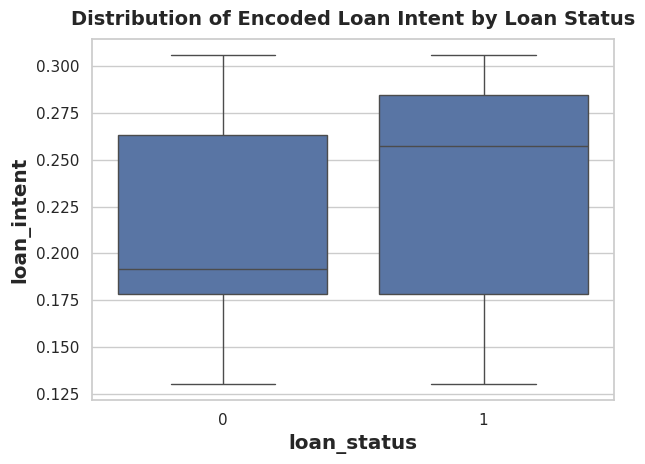

In [ ]:
data = pd.concat([X_trn['loan_status'], X_trn_mencod['loan_intent']], axis= 1)


sns.boxplot(x= 'loan_status', y= 'loan_intent', data= data)
plt.title('Distribution of Encoded Loan Intent by Loan Status')
plt.show()


In [ ]:
data.head(2)

,loan_status,loan_intent
20219,0,0.130435
32054,1,0.257162


## pipeline

In [ ]:
X_trn.head(3)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,isna_person_emp_length,isna_loan_int_rate
30951,37,48000,RENT,6.0,PERSONAL,B,4200,10.59,0,0.09,N,14,False,False
26938,27,120000,MORTGAGE,11.0,EDUCATION,B,20000,10.65,0,0.17,N,8,False,False
5944,26,41682,MORTGAGE,7.0,DEBTCONSOLIDATION,C,18000,13.22,1,0.43,Y,3,False,False


In [ ]:
# Remove rows with missing target
X_trn.dropna(axis= 0, subset= ['loan_status'], inplace= True)

KeyError: ['loan_status']

In [ ]:
target = 'loan_status'
y_trn, y_tst = X_trn[target], X_tst[target]
X_trn = X_trn[cols_num + cols_cat]
X_tst = X_tst[cols_num + cols_cat]

In [ ]:
# a pipeline bundles preprocessing & modeling steps as if it were a single step.
# it's a simple way to keep the dat preprocessing & modeling code organized.

# advantages of an ml pipeline:
# 1) cleaner code
# this way you won't need to manually keep track of various steps.

# 2) fewer bugs
# your code will be less prone to m forgetting or misapplying a preprocessing step.

# 3) easier to productionize
# pipeline can help the transition from prototype model to sth deployable at scale.

# 4) more options for model validation

In [ ]:
# ColumnTransforme: bundles together various preprocessing steps
# Pipeline: bundles together preprocessing & modeling steps

# preprocessing for numerical data
transforms_num = SimpleImputer(strategy= 'constant')

# preprocessing for categorical data
transforms_cat = Pipeline(steps= [
    ('imputer', SimpleImputer(strategy= 'most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown= 'ignore', sparse= False))
])

In [ ]:
# bundle preprocessing for numerical & categorical data:
transforms = ColumnTransformer(transformers= [
    ('num', transforms_num, cols_num),
    ('cat', transforms_cat, cols_cat)
])

In [ ]:
model = RandomForestClassifier(n_estimators= 50, random_state= 0)
model

RandomForestClassifier(n_estimators=50, random_state=0)

In [ ]:
pipe = Pipeline(steps= [
    ('transforms', transforms),
    ('model', model)
])

pipe.fit(X_trn, y_trn)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('transforms',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='constant'),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['person_home_ownership',
                                                   'loan_intent'])])),
                ('model',
                 RandomForestClassifier(n_estimators=50, random_state=0))])

In [ ]:
preds = pipe.predict(X_tst)

## cross-validation

In [ ]:
# goal: how to use cross-validation for better measures of model performance.
# in `cross-validation`, we run our modeling process on different subsets of the data
# to get multiple measures of model quality.

# CV gives a more accurate measure of model quality,
# which is especially important if you're making a lot of modeling decisions.
# HOWEVER, it can take longer to run, because it estimates multiple models
# (one for each fold.)

# REMEMBER: Ml is an iterative process.

In [ ]:
scores = cross_val_score(pipe, X_trn, y_trn, cv= 5, scoring= 'roc_auc')
scores

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

array([0.63674607, 0.69673295, 0.68866289, 0.76234691, 0.68324361])

In [ ]:
# N.B. the scores for various folds differe rather significantly.
# Hence, not the best model yet for the dataset?
scores.mean().round(3)

0.694

In [ ]:
# N.B. (aside):
# sklearn has a convention where all metrics are defined so a high number is better.
# scores = -1 * cross_val_score(pipe, X, y, cv= 3, scoring= 'neg_mean_absolute_error')


## Hyperparameter Optimization

In [ ]:
# a naive approach
def get_score(n_estimators):
    pipe = Pipeline(steps= [
        ('transforms', SimpleImputer(strategy= 'constant')),
        ('model', RandomForestClassifier(n_estimators= n_estimators, random_state= 0))
    ])

    scores = cross_val_score(pipe, X_trn[cols_num], y_trn, cv= 3, scoring= 'roc_auc')
    return scores.mean().round(3)


In [ ]:
ntrees = [50 * i for i in range(1, 4)]

scores = [get_score(n) for n in ntrees]

results = {n: s for n, s in zip(ntrees, scores)}
results

{50: 0.624, 100: 0.625, 150: 0.625}

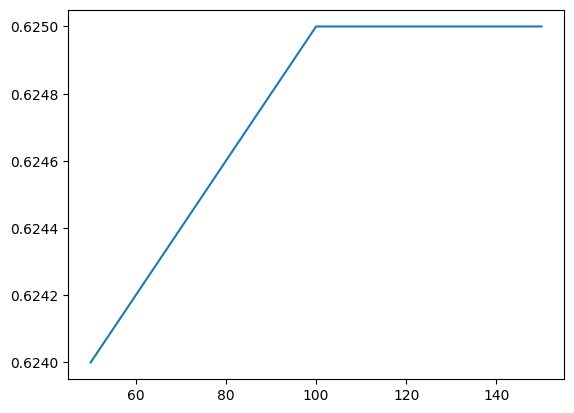

In [ ]:
plt.plot(list(results.keys()), list(results.values()))


In [ ]:
# grid search

## XGBoost

In [ ]:
# gradient boosting:
# it's a method that goes through cycles to iteratively add models to an ensemble.

In [ ]:
# the "gradient" in `gradient boosting` refers to the fact that
# we'll use "gradient descent" on the loss function
# to determine the parameters of the new model at each step.
# subsequent additions to the ensemble will address the errors from previous step.

In [ ]:
model = xgb.XGBClassifier(n_estimators= 50, learning_rate= .05)
model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
# learning_rate:
# we first multiply the predictions from each model by a small number,
# the learning_rate,
# before adding them in.
# i.e., each tree we add to the ensemble helps us less.
# So, we can set a higher value for `n_estimators` withought overfitting, hopfefully.

# In general, a small learning_rate and large n_estimators will yield more accurate
# XGBoost models, though it will also take the model longer to train
# since it does more iterations through the cycle.

In [ ]:
# n_jobs
# only care about it when fitting a large dataset.
# it's customery to set `n_jobs` to the number of cores on the machine.
# this way you can build the models faster via parallelism.

In [ ]:
import os
os.cpu_count()

2

In [ ]:
import psutil

print(f"Number of logical cores: {psutil.cpu_count(logical= True)}")

print(f"Number of physical cores: {psutil.cpu_count(logical= False)}")


Number of logical cores: 2
Number of physical cores: 1


In [ ]:
# `early_stopping_rounds`
# offers a way to automatically find the ideal value for `n_estimators`
# it causes the model to stop iterating when the validation score stops improving,
# even if we're not at the hard stop for `n_estimators`.

In [ ]:
model.fit(X_trn[cols_num], y_trn,
          eval_set= [(X_tst[cols_num], y_tst)],
          #eval_metric= 'logloss',
          #early_stopping_rounds= 5,
          verbose= True)

[0]	validation_0-logloss:0.50284
[1]	validation_0-logloss:0.49828
[2]	validation_0-logloss:0.49475
[3]	validation_0-logloss:0.49147
[4]	validation_0-logloss:0.48879
[5]	validation_0-logloss:0.48590
[6]	validation_0-logloss:0.48283
[7]	validation_0-logloss:0.48025
[8]	validation_0-logloss:0.47783
[9]	validation_0-logloss:0.47588
[10]	validation_0-logloss:0.47359
[11]	validation_0-logloss:0.47198
[12]	validation_0-logloss:0.47048
[13]	validation_0-logloss:0.46900
[14]	validation_0-logloss:0.46766
[15]	validation_0-logloss:0.46600
[16]	validation_0-logloss:0.46481
[17]	validation_0-logloss:0.46344
[18]	validation_0-logloss:0.46244
[19]	validation_0-logloss:0.46135
[20]	validation_0-logloss:0.46059
[21]	validation_0-logloss:0.45948
[22]	validation_0-logloss:0.45864
[23]	validation_0-logloss:0.45821
[24]	validation_0-logloss:0.45803
[25]	validation_0-logloss:0.45751
[26]	validation_0-logloss:0.45692
[27]	validation_0-logloss:0.45647
[28]	validation_0-logloss:0.45616
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
model.fit(X_trn[cols_num], y_trn,
          eval_set= [(X_tst[cols_num], y_tst)],
          eval_metric= 'logloss',
          early_stopping_rounds= 5,
          verbose= True)

TypeError: XGBClassifier.fit() got an unexpected keyword argument 'eval_metric'

## Data Leakage

## Feature Engineering

In [ ]:
# one of the most important steps on the way to building a great ml model:
# feature engineering
# a proper feature engineering will make the data better suited to the problem at hand.

# you'll learn:
# determine which features are the most important with `mutual information`
# invent new features in several real-world problem domains
# encode high-cardinality categoricals with a `target encoding`
# create segmentation features with k-means clustering
# decompose a dataset's variation into features with `principal component analysis`

,loan_status
20219,0
32054,1
28546,0
14843,0
8194,1
...,...
28275,0
28526,0
6993,0
26427,0


## multicollinear

In [ ]:
XX = X_trn[cols_num]
XX = XX.fillna(0)

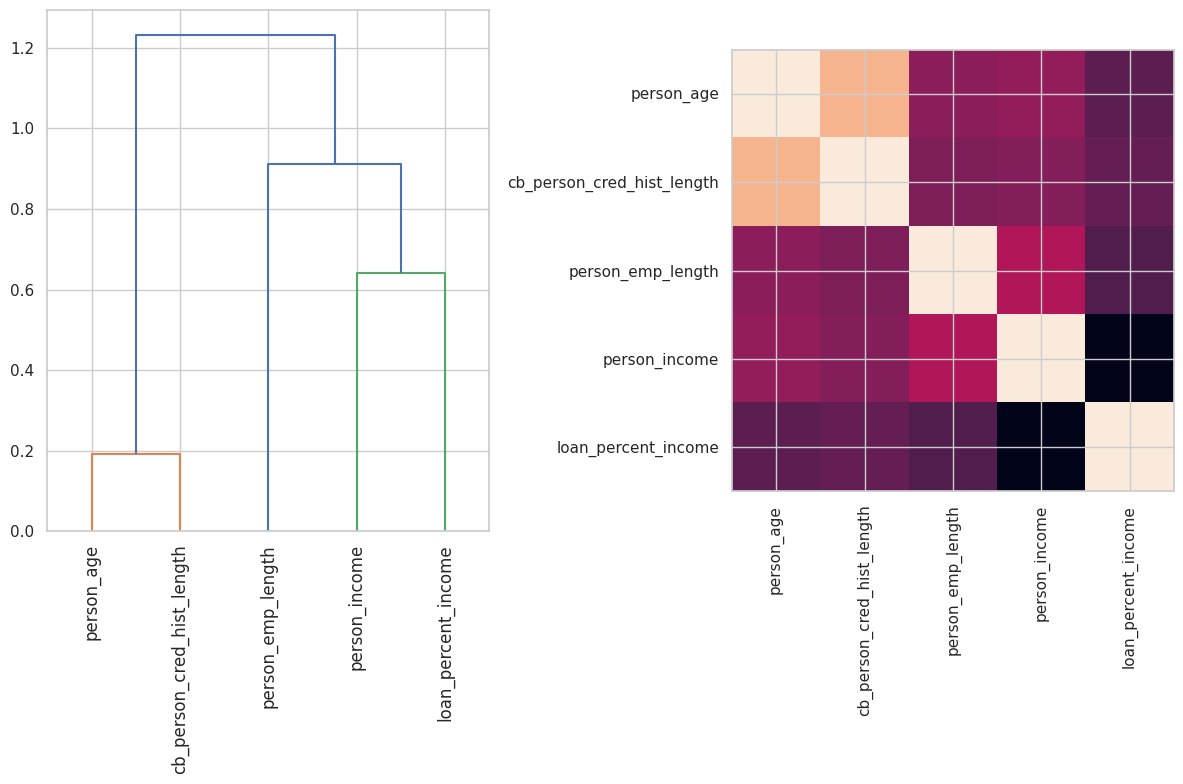

In [ ]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (12, 8))
corr = spearmanr(XX).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix
# before performing a hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels= XX.columns.to_list(), ax= ax1, leaf_rotation= 90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation= 'vertical')
ax2.set_yticklabels(dendro['ivl'])
_ = fig.tight_layout()